#**АИС. Лабораторная работа №5**

**Максимов Антон, 17ПМИ**

In [0]:
import numpy as np
import networkx as nx 
import pandas as pd
import matplotlib.pyplot as plt
from numpy import loadtxt
from scipy.optimize import linprog as simplex
from collections import deque
import random
import timeit
import sys
import re
import time

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [5]:
cd /content/gdrive/'My Drive'/АИО/vrp/A/

/content/gdrive/My Drive/АИО/vrp/A


In [0]:
a=!ls -1  *.*

In [7]:
a[0]

'A-n32-k5.vrp'

In [0]:
class Reader:
    def __init__(self, filename):

        self.problem = filename
        self.capacity = None
        self.number_of_trucks = None
        self.depot = None
        self.coords = []
        self.demands = []
        self.read_file(self.problem)
        self.distance_matrix = self.calculate_distance_matrix()

    def read_file(self, problem):
        reading_coords = False
        reading_demand = False
        reading_depot = False
        content = open(problem).read().replace('\r', ' ').replace('\n', ' ')
        self.number_of_trucks = int(re.search('No of trucks: ([0-9]+)', content).group(1))
        self.capacity = int(re.search('CAPACITY : ([0-9]+)', content).group(1))
        with open(problem, 'r') as f:

            for line in f.readlines():
                contents = line.split(' ')

                if 'NODE_COORD_SECTION' in contents[0]:
                    reading_coords = True
                    continue
                if 'DEMAND_SECTION' in contents[0]:
                    reading_demand = True
                    reading_coords = False
                    continue
                if 'DEPOT_SECTION' in contents[0]:
                    reading_depot = True
                    reading_demand = False
                    reading_coords = False
                    continue

                if reading_coords:
                    self.coords.append([int(contents[2]), int(contents[3])])

                if reading_demand:
                    self.demands.append(int(contents[1]))

                if reading_depot:
                    self.depot = int(contents[1]) - 1
                    break

    def calculate_distance_matrix(self):
        distances_matrix = []
        for i_coord in self.coords:
            distances = []
            for j_coord in self.coords:
                distance = int(round(np.linalg.norm(np.subtract(i_coord, j_coord))))
                distances.append(distance)
            distances_matrix.append(distances)
        return distances_matrix

In [0]:
test = Reader(a[0])

In [74]:
print(test.problem)
print(test.capacity)
print(test.number_of_trucks)
print(test.depot)
print(test.coords)
print(test.demands)

A-n32-k5.vrp
100
5
0
[[82, 76], [96, 44], [50, 5], [49, 8], [13, 7], [29, 89], [58, 30], [84, 39], [14, 24], [2, 39], [3, 82], [5, 10], [98, 52], [84, 25], [61, 59], [1, 65], [88, 51], [91, 2], [19, 32], [93, 3], [50, 93], [98, 14], [5, 42], [42, 9], [61, 62], [9, 97], [80, 55], [57, 69], [23, 15], [20, 70], [85, 60], [98, 5]]
[0, 19, 21, 6, 19, 7, 12, 16, 6, 16, 8, 14, 21, 16, 3, 22, 18, 19, 1, 24, 8, 12, 4, 8, 24, 24, 2, 20, 15, 2, 14, 9]


In [0]:
def save(filename, cost, routes):
    name, ext = filename.split('.')
    solution = '{}.{}'.format(name, 'sol')
    with open(solution, 'w')as f:
        f.write(routes)
        f.write("cost: " + str(cost) + '\n')

In [0]:
def to_solution_file(trips):
    s = ''
    for index, trip in enumerate(trips):
        line = 'Route #' + str(index + 1) + ": "
        for city, _ in trip:
            if city == 0:
                break
            line += str(city) + " "

        s += line + '\n'
    return s

##**Ant Colony**

###**Ant Class**

In [0]:
class Ant:
    def __init__(self, capacity, warehouse, demands, distance_matrix, pheromone, alpha, beta):
        self.current_city = warehouse
        self.warehouse = warehouse
        self.distance_matrix = distance_matrix
        self.not_visited = self.create_not_visited(distance_matrix)
        self.capacity = capacity
        self.load = capacity
        self.demands = demands
        self.trips = []
        self.current_trip = []
        self.pheromone = pheromone
        self.trips_distance = None
        self.alpha = alpha
        self.beta = beta

        self.start()

    def create_not_visited(self, distance_matrix):
        not_visited = set()
        for i, tmp in enumerate(distance_matrix):
            if i != self.warehouse:
                not_visited.add(i)
        return not_visited

    def start(self):
        from random import randint
        start_city = randint(1, len(self.distance_matrix) - 1)
        self.visit_city(start_city)

    def visit_city(self, index):
        self.not_visited.remove(index)
        self.load -= self.demands[index]
        distance = self.distance_matrix[self.current_city][index]
        self.current_city = index
        self.current_trip.append((index, distance))

    def visit_warehouse(self):
        self.load = self.capacity
        distance = self.distance_matrix[self.current_city][self.warehouse]
        self.current_city = self.warehouse
        self.current_trip.append((self.warehouse, distance))
        self.trips.append(self.current_trip)
        self.current_trip = []

    def get_pheremone_intensity(self, city):
        return self.pheromone.get_pheromone_trail(self.current_city, city)

    def get_attractiveness(self, city):
        distance = self.distance_matrix[self.current_city][city]
        if distance == 0:
            return 1
        return 1 / distance

    def calc_val(self, city):
        pheremone_intensity = self.get_pheremone_intensity(city)
        attractiveness = self.get_attractiveness(city)
        return pow(pheremone_intensity, self.alpha) * pow(attractiveness, self.beta)

    def get_neighbours_with_probab(self):
        not_visited = list(self.not_visited)

        l = [self.calc_val(city) for city in not_visited]
        prob = np.divide(l, sum(l))

        for i in range(1, len(prob)):
            prob[i] += prob[i - 1]
        return not_visited, prob

    def create_path(self):
        while len(self.not_visited) > 0:
            neighbours, probabilities = self.get_neighbours_with_probab()
            r = random.random()
            next_to_visit = neighbours[-1]
            for i in range(len(probabilities)):
                if r < probabilities[i]:
                    next_to_visit = neighbours[i]
                    break

            if self.demands[next_to_visit] > self.load:
                self.visit_warehouse()
            else:
                self.visit_city(next_to_visit)

        self.visit_warehouse()

    def calculate_paths_quality(self):
        overall_distance = 0
        for trip in self.trips:
            for _, dist in trip:
                overall_distance += dist
        self.trips_distance = overall_distance

    def global_update(self):
        for trip in self.trips:
            prev_city = self.warehouse
            for i, (city, _) in enumerate(trip):
                self.pheromone.update(prev_city, city, self.trips_distance)
                prev_city = city
            self.pheromone.update(prev_city, self.warehouse, self.trips_distance)

    def local_update(self):
        for trip in self.trips:
            prev_city = self.warehouse    
            for i, (city, _) in enumerate(trip):
                self.pheromone.local_update_pheremone(prev_city, city)
                prev_city = city
            self.pheromone.local_update_pheremone(prev_city, self.warehouse)

    def reset(self):
        self.current_city = 0
        self.not_visited = self.create_not_visited(self.distance_matrix)
        self.current_trip = []
        self.trips = []
        self.load = self.capacity
        self.start()

###**Pheromone Class**

In [0]:
class Pheromone:
    def __init__(self, number_of_cities):
        from random import uniform
        self.pheromones_matrix = []
        self.Q = 1
        self.RHO = 0.2
        self.tau0 = 0.001
        for distances in range(number_of_cities):
            pheromones = [self.tau0 for _ in range(number_of_cities)]
            self.pheromones_matrix.append(pheromones)

    def get_pheromone_trail(self, city_i, city_j):
        return self.pheromones_matrix[city_i][city_j]

    def evaporate(self):
        self.pheromones_matrix = np.multiply(self.pheromones_matrix, (1 - self.RHO)) #функция для подсчета испарений

    def local_update_pheremone(self, city_i, city_j):
        self.pheromones_matrix[city_i][city_j] += self.RHO*self.tau0 
        self.pheromones_matrix[city_j][city_i] += self.RHO*self.tau0 

    def update(self, city_i, city_j, overall_trip_distance): 
        delta_tau = self.Q / overall_trip_distance
        self.pheromones_matrix[city_i][city_j] += delta_tau
        self.pheromones_matrix[city_j][city_i] += delta_tau

###**Algorithm**

In [0]:
def Ant_Colony_Algorithm(filename):
  random.seed(3)
  ALPHA = 1  #наиболее оптимальные параметры в статье
  BETA = 5
  data = Reader(filename)
  capacity = data.capacity
  depot = data.depot
  demands = data.demands
  distance_matrix = data.distance_matrix
  number_of_cities = len(distance_matrix)
  number_of_ants = number_of_cities
  iterations = 1000
  pheromone = Pheromone(number_of_cities)
  ants = [Ant(capacity, depot, demands, distance_matrix, pheromone, ALPHA, BETA) for i in range(number_of_ants)]
  best_cost = np.inf
  routes = ''
  no_change = 0
  best_ant = None
  avg_cost = []
  last = np.inf
  
  for iteration in range(iterations):
    best_ants = []
    for ant in ants:

      ant.create_path()
      ant.calculate_paths_quality()

      if ant.trips_distance < best_cost:
        best_ants.append(ant)
        best_cost = ant.trips_distance
        best_ant = ant
        
        routes = trips_to_str(ant.trips)
      avg_cost.append(ant.trips_distance)  

    for ant in ants:

      pheromone.evaporate()
      ant.local_update()

      if ant in best_ants:
        ant.global_update()  
      ant.reset()
      
    fitness = (best_cost - np.mean(avg_cost)) / best_cost
    if iteration % 100 == 0:
        if abs(last - fitness) < 0.00001:
                        break
    last = fitness

  #save(filename, best_cost, routes)
  return routes, best_cost
     

In [159]:
routes, best_cost = Ant_Colony_Algorithm(a[1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide


###**Visualization**

In [261]:
c = Reader(a[1])
routes, best_cost = Ant_Colony_Algorithm(a[1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide


In [0]:
def to_new_routes(routes):
    new_routes = []
    routes = routes.split(' ')
    collect = False
    for i in range(len(routes)):
      #print(routes[i][0])
      
      if routes[i][0]=='#':
        collect = True
        new_route = []
        continue

      if routes[i][0]=='\n':
        collect = False
        new_routes.append(new_route)

      if collect==True:
        new_route.append(int(routes[i]))   
      
    return new_routes    


In [183]:
new_routes = to_new_routes(routes)
new_routes

[[17, 19, 31, 21, 13, 7],
 [27, 24, 14, 30, 26, 16],
 [20, 5, 25, 10, 29, 15, 22, 9, 18, 8],
 [11, 4, 28, 23, 2, 3, 6],
 [12, 1]]

In [0]:
def draw_graph(routes, best_cost, coords, distance_matrix, filename):
    G = nx.Graph()
    crs = ['g','r','b', 'y', 'm'] #можно добавить цвета
    n = 0
    for route in routes:
        i = 0
        for city in route:
            G.add_edge(i, city, color=crs[n], weight=distance_matrix[i][city])
            i = city
        G.add_edge(i, 0, color=crs[n], weight=distance_matrix[i][0])
        n = n + 1
        
    edgelist = [(u, v) for (u, v, d) in G.edges(data=True)]

    for i, pos in enumerate(coords):
        G.add_node(i, pos=pos)
    pos = nx.get_node_attributes(G, 'pos')
    edges = G.edges()
    colors = [G[u][v]['color'] for u,v in edges]
    print("FILENAME: ", filename)
    print("BEST COST: ", best_cost)
    
    plt.figure(figsize=(12, 12))
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, label_pos=0.5) 
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_edges(G, pos, edgelist=edgelist,edge_color=colors)
    nx.draw_networkx_labels(G, pos)
    plt.axis('off')
    plt.show()

FILENAME:  A-n32-k5.vrp
BEST COST:  842


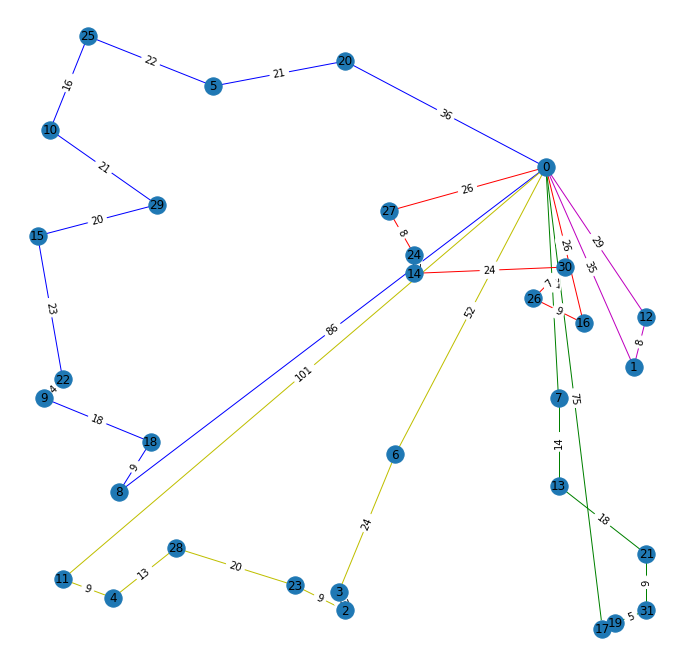

In [258]:
draw_graph(new_routes, best_cost, c.coords, c.distance_matrix, c.problem)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide


FILENAME:  A-n33-k5.vrp
BEST COST:  698


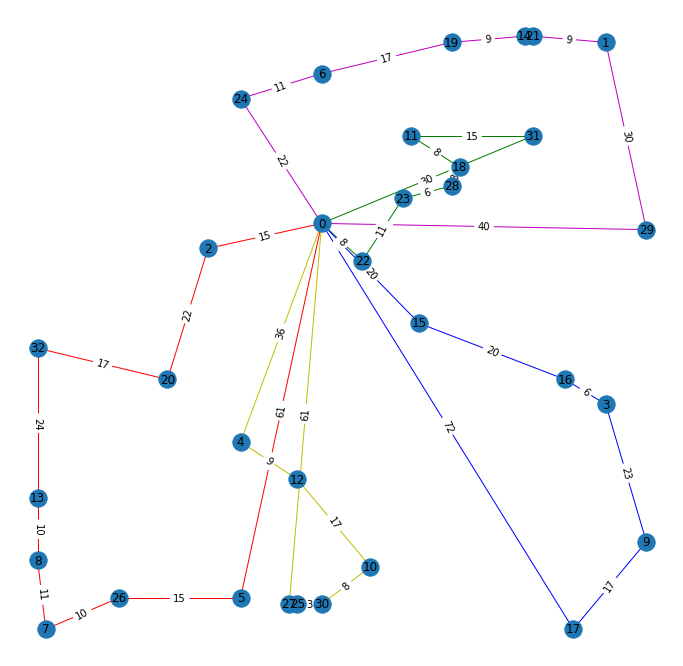

In [259]:
c = Reader(a[3])
routes, best_cost = Ant_Colony_Algorithm(a[3])
new_routes = to_new_routes(routes)
draw_graph(new_routes, best_cost, c.coords, c.distance_matrix, c.problem)

###**Testing**

In [0]:
a=!ls -1  *.*

In [0]:
a

In [150]:
cd /content/gdrive/'My Drive'/АИО/vrp/A/

/content/gdrive/My Drive/АИО/vrp/A


In [143]:
A_test = []
costs = []
for test in a:
  start = time.time()
  data = Reader(test)
  routes, best_cost = Ant_Colony_Algorithm(test)
  finish = time.time()
  tm = finish - start
  A_test.append(tm)
  costs.append(best_cost)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide


####**A-test**

In [144]:
df = pd.DataFrame({
'Filename': a,
'Time': A_test,
'Cost': costs,
})
df

,Filename,Time,Cost
0,A-n32-k5.vrp,22.749238,842
1,A-n33-k5.vrp,37.526668,698
2,A-n33-k6.vrp,12.712222,799
3,A-n34-k5.vrp,40.178442,810
4,A-n36-k5.vrp,40.316879,875
5,A-n37-k5.vrp,17.181877,755
6,A-n37-k6.vrp,27.007061,981
7,A-n38-k5.vrp,95.423884,791
8,A-n39-k5.vrp,51.003719,899
9,A-n39-k6.vrp,73.201331,893


In [145]:
cd /content/gdrive/'My Drive'/АИО/vrp/B/

/content/gdrive/My Drive/АИО/vrp/B


In [0]:
b=!ls -1  *.*

In [147]:
B_test = []
b_costs = []
for test in b:
  start = time.time()
  data = Reader(test)
  routes, best_cost = Ant_Colony_Algorithm(test)
  finish = time.time()
  tm = finish - start
  B_test.append(tm)
  b_costs.append(best_cost)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide


####**B-test**

In [148]:
df = pd.DataFrame({
'Filename': b,
'Time': B_test,
'Cost': b_costs,
})
df

,Filename,Time,Cost
0,B-n31-k5.vrp,31.890083,672
1,B-n34-k5.vrp,34.612769,803
2,B-n35-k5.vrp,22.071735,985
3,B-n38-k6.vrp,77.227595,826
4,B-n39-k5.vrp,40.832875,583
5,B-n41-k6.vrp,35.935623,874
6,B-n43-k6.vrp,54.001265,782
7,B-n44-k7.vrp,149.580765,961
8,B-n45-k5.vrp,77.138081,824
9,B-n45-k6.vrp,110.055633,741
